In [275]:
import requests
import json
import urllib.parse
import pandas as pd
import time

# pip install python-dotenv
# Use the "%env" command to set API Keys
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
findPlace = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"
nearbySearch = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
distanceMatrix = "https://maps.googleapis.com/maps/api/distancematrix/json"

df = pd.read_csv("XternPlaces.csv", header=None)
df.columns = ['name', 'address', 'type']
housing = df.iloc[0]
workspaces = df.iloc[1:6]

In [332]:
# Get the location of the housing
housingPlace = []
response = requests.request("GET", findPlace + 
                            "?input=" + urllib.parse.quote(housing['address']) + 
                            "&inputtype=textquery" +
                            "&fields=place_id,geometry" +
                            "&key=" + API_KEY,
                            headers={}, data={})
if(response.ok):
    housingJson = json.loads(response.text)
    housingID = housingJson['candidates'][0]['place_id']
    housingCoordinates = housingJson['candidates'][0]['geometry']['location']
else:
    print(response)

# Get the location of the workspaces
workspaceIDs = []
workspaceCoordinates = []
workspaceRatings = []
for index, workspaceAddress in workspaces['address'].items():
    response = requests.request("GET", findPlace +  
                                "?input=" + urllib.parse.quote(workspaceAddress) + 
                                "&inputtype=textquery" +
                                "&fields=place_id,geometry" +
                                "&key=" + API_KEY,
                                headers={}, data={})
    if(response.ok):
        workspaceJson = json.loads(response.text)
        workspaceIDs.append(workspaceJson['candidates'][0]['place_id'])
        workspaceCoordinates.append(workspaceJson['candidates'][0]['geometry']['location'])
    else:
        print(response)

In [285]:
# Find distance between housing and workspaces
workspaceDistances = []
for workspaceID in workspaceIDs:
    response = requests.request("GET", distanceMatrix +
                                "?destinations=place_id:" + urllib.parse.quote(workspaceID) +
                                "&origins=place_id:" + urllib.parse.quote(housingID) + 
                                "&units=imperial" +
                                "&key=" + API_KEY,
                                headers={}, data={})
    if(response.ok):
        distanceJson = json.loads(response.text)
        workspaceDistances.append(distanceJson['rows'][0]['elements'][0]['distance']['text'])
    else:
        print(response)

['7.2 mi', '17.4 mi', '22.4 mi', '1.9 mi', '2.5 mi']


In [392]:
# Find nearby places of interest 
workspaceActivityData = []
workspaceRestaurantData = []
for workspace in workspaceCoordinates:
    nearbyRestaurants = []
    nearbyActivities = []  
        
    def nextPage(placeList, token, secondPage):
        nextPageResponse = requests.request("GET", nearbySearch +  
                            "?key=" + API_KEY +
                            "&pagetoken=" + token,
                            headers={}, data={})
        if(nextPageResponse.ok):
            nextPageResponseJson = json.loads(nextPageResponse.text)['results']
            if nextPageResponseJson != []:
                placeList.append(nextPageResponseJson)
                if(secondPage):
                    #We can only get 3 pages of results
                    time.sleep(3)
                    nextPage(placeList, token, False)
        else:
            print(nextPageResponse) 
        
    def findNearby(placeType, placeList, radius):
        response = requests.request("GET", nearbySearch +  
                                    "?location=" + urllib.parse.quote(str(workspace['lat']) + "," + str(workspace['lng'])) + 
                                    "&radius=" + str(radius) +
                                    "&type=" + placeType +
                                    "&key=" + API_KEY,
                                    headers={}, data={})
        if(response.ok):
            responseJson = json.loads(response.text)
            if responseJson['results'] != []:
                placeList.append(responseJson['results'])
                if('next_page_token' in responseJson):
                    #Delay betweeen when next page token is created and when it is accessible
                    time.sleep(3)
                    nextPage(placeList, responseJson['next_page_token'], True)
        else:
            print(response)
            
    def findDistanceMatrix(placeID):
        distanceSum = 0
        response = requests.request("GET", distanceMatrix +
                                "?destinations=place_id:" + urllib.parse.quote(placeID) +
                                "&origins=" + urllib.parse.quote(str(workspace['lat']) + "," + str(workspace['lng'])) + 
                                "&units=imperial" +
                                "&key=" + API_KEY,
                                headers={}, data={})
        if(response.ok):
            distanceJson = json.loads(response.text)
            distanceString = distanceJson['rows'][0]['elements'][0]['distance']['text']
            distance = 0
            if("mi" in distanceString):
                distance = float(distanceString.replace("mi", ""))
            if("ft" in distanceString):
                distance = float(distanceString.replace("ft", "")) / 5280
            distanceSum += distance
        else:
            print(response)
        return distanceSum
    
    findNearby("restaurant", nearbyRestaurants, 4025)
    findNearby("art", nearbyActivities, 8050)
    findNearby("museum", nearbyActivities, 8050)
    findNearby("tourist_attraction", nearbyActivities, 8050)
    findNearby("aquarium", nearbyActivities, 8050)
    findNearby("zoo", nearbyActivities, 8050)
    findNearby("movie_theater", nearbyActivities, 8050)
    findNearby("sport", nearbyActivities, 8050)
    findNearby("bowling_alley", nearbyActivities, 8050)
    
    # Filter the highest rated restaurants
    topRestaurants = []
    restaurantNames = []
    topRestaurantsRatings = 0
    topRestaurantsDistances = 0
    for restaurantGroups in nearbyRestaurants:
        for restaurant in restaurantGroups:
            #If the business operational and not a fast food chain and not a duplicate
            if(("business_status" in restaurant and restaurant['business_status'] == "OPERATIONAL") and ("price_level" in restaurant and restaurant['price_level'] > 1) and (restaurant['name'] not in restaurantNames)):
                restaurantNames.append(restaurant['name'])
                topRestaurants.append(restaurant)

    topRestaurants.sort(reverse=1, key=lambda restaurant: 0 if("rating" not in restaurant) else restaurant['rating'])
    topRestaurants = topRestaurants[0 : 20]
    
    for restaurant in topRestaurants:
        topRestaurantsRatings += restaurant['rating']
        topRestaurantsDistances += findDistanceMatrix(restaurant['place_id'])
    restaurantAverageRating = topRestaurantsRatings/len(topRestaurants)
    restaurantAverageDistance = topRestaurantsDistances/len(topRestaurants)
    
    workspaceRestaurantData.append([nearbyRestaurants, restaurantAverageRating, restaurantAverageDistance, topRestaurants])
    
    # Filter the highest rated activites
    topActivities = []
    activityTypes = []
    activityNames = []
    topActivitiesDistances = 0
    for activityGroup in nearbyActivities:
        for activity in activityGroup:
            #Prevent duplicates
            if activity['name'] not in activityNames:
                activityNames.append(activity['name'])
                topActivities.append(activity)
                for activityType in activity['types']:
                    if(activityType not in activityTypes and activityType in ("art", "museum", "tourist_attraction", "aquarium", "zoo", "movie_theater", "sport", "bowling_alley")):
                        activityTypes.append(activityType)

    topActivities.sort(reverse=1, key=lambda activity: 0 if("rating" not in activity) else activity['rating'])
    topActivities = topActivities[0 : 10]
    
    for activity in topActivities:
        topActivitiesDistances += findDistanceMatrix(activity['place_id'])
    
    activityAverageDistance = topActivitiesDistances/len(topActivities)
    
    workspaceActivityData.append([nearbyActivities, activityAverageDistance, activityTypes, topActivities])


In [393]:
# Create dataframes
housingDistanceRows = []
restaurantRows = []
activityRows = []
topRestaurantRows = []
topActivityRows = []
for index, workspaceName in workspaces['name'].items():
    distanceFromHousing = 0
    if("mi" in workspaceDistances[index-1]):
        distanceFromHousing = float(workspaceDistances[index-1].replace("mi", ""))
    if("ft" in workspaceDistances[index-1]):
        distanceFromHousing = float(workspaceDistances[index-1].replace("ft", "")) / 5280
    housingDistanceRow = [workspaceName, distanceFromHousing]
    housingDistanceRows.append(housingDistanceRow)
    
    restaurantRow = [workspaceName, workspaceRestaurantData[index-1][1], 
           workspaceRestaurantData[index-1][2]]
    restaurantRows.append(restaurantRow)
    
    topRestaurantRows.append([workspaceName, workspaceRestaurantData[index-1][3]])
    
    activityRow = [workspaceName, workspaceActivityData[index-1][1], 
                   len(workspaceActivityData[index-1][2]) ]
    activityRows.append(activityRow)
    
    topActivityRows.append([workspaceName, workspaceActivityData[index-1][3]])
    
housingDistanceDF = pd.DataFrame(housingDistanceRows)
housingDistanceDF.style.set_caption("Distance from Housing")
housingDistanceDF.columns = ["Name", "Distance (miles)"]
housingDistanceDF.set_index("Name", inplace=True)

restaurantDF = pd.DataFrame(restaurantRows)
restaurantDF.style.set_caption("Distance and Rating of Top 20 Nearby Restaurants")
restaurantDF.columns = ["Name", "Average Restaurant Rating", "Average Restaurant Distance (miles)"]
restaurantDF.set_index("Name", inplace=True)

topRestaurantDF = pd.DataFrame(topRestaurantRows)
topRestaurantDF.columns = ["Name", "Top Restaurants"]
topRestaurantDF.set_index("Name", inplace=True)

activityDF = pd.DataFrame(activityRows)
activityDF.style.set_caption("Distance and Rating of Top 10 Nearby Activities")
activityDF.columns = ["Name", "Average Activity Distance (miles)", "Number of Different Activity Types"]
activityDF.set_index("Name", inplace=True)

topActivityDF = pd.DataFrame(topActivityRows)
topActivityDF.columns = ["Name", "Top 10 Nearby Activities"]
topActivityDF.set_index("Name", inplace=True)

restaurantDF

,Average Restaurant Rating,Average Restaurant Distance (miles)
Name,,
The Speak Easy,4.475000,1.335000
zWORKS,4.365000,1.443352
Launch Fishers,4.347059,1.923529
Industrious Mass Ave,4.515000,0.892396
Launch Indy,4.500000,0.765000


In [394]:
activityDF

,Average Activity Distance (miles),Number of Different Activity Types
Name,,
The Speak Easy,3.39,4
zWORKS,3.81,3
Launch Fishers,3.17,4
Industrious Mass Ave,0.88,4
Launch Indy,0.99,5


<AxesSubplot:ylabel='Name'>

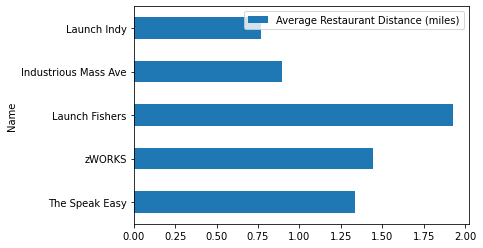

In [395]:
restaurantDF.plot.barh(y='Average Restaurant Distance (miles)')

<AxesSubplot:ylabel='Name'>

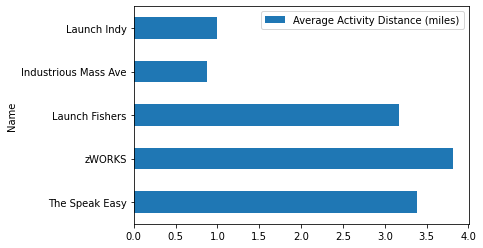

In [396]:
activityDF.plot.barh(y='Average Activity Distance (miles)')

In [397]:
housingDistanceDF

,Distance (miles)
Name,
The Speak Easy,7.2
zWORKS,17.4
Launch Fishers,22.4
Industrious Mass Ave,1.9
Launch Indy,2.5


In [398]:
#Top Activities and Restaurants for the chosen workspace
topActivitiesInfo = []
for activity in topActivityDF.loc['Industrious Mass Ave'].values[0]:
    topActivitiesInfo.append([activity['name'], activity['rating']])
    
topRestaurantsInfo = []
for restaurant in topRestaurantDF.loc['Industrious Mass Ave'].values[0]:
    topRestaurantsInfo.append([restaurant['name'], restaurant['price_level'], restaurant['rating']])

In [399]:
topActivitiesInfoDF = pd.DataFrame(topActivitiesInfo)
topActivitiesInfoDF.columns = ["Name", "Rating"]
topActivitiesInfoDF.set_index("Name", inplace=True)

topRestaurantsInfoDF = pd.DataFrame(topRestaurantsInfo)
topRestaurantsInfoDF.columns = ["Name", "Price Level", "Rating"]
topRestaurantsInfoDF.set_index("Name", inplace=True)

In [400]:
topActivitiesInfoDF

,Rating
Name,
Vintage White Castle building #3,5.0
Station No. 2 Fire Museum,5.0
"WRSP Memorial - Welch, Carroll, McKinney & Weliever",5.0
Firefighters Museum & Survive Alive,4.9
The HandleBar,4.9
Kurt Vonnegut Museum and Library,4.8
Indianapolis Fire Fighters Museum,4.8
Holy Rosary Church,4.8
Saint John the Evangelist,4.8


In [401]:
topRestaurantsInfoDF

,Price Level,Rating
Name,,
St. Elmo Steak House,4,4.7
Harry & Izzy's,4,4.7
Bluebeard,3,4.7
Fogo de Chão Brazilian Steakhouse,3,4.6
Ruth's Chris Steak House,4,4.6
Chatham Tap Mass Ave,2,4.6
The Capital Grille,4,4.6
Iaria's Italian Restaurant,2,4.6
The Rathskeller,2,4.5
